### Etapa 1: Inicialização da Sessão Spark (camada Gold)

Nesta etapa realizo a criação e configuração da sessão Spark com suporte ao Delta Lake.
Essa sessão será utilizada para carregar, transformar e analisar os dados da camada Gold.

**Resultado esperado:**  
A sessão Spark deve ser criada corretamente e exibida na saída da clula.
o.


In [1]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder
        .appName("mvp_turnover_gold")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

spark


### Etapa 2: Carregamento da Camada Silver

Nesta etapa carrego a tabela Silver (`delta_ibm_hr_silver`) em formato Delta e converto os dados
para um DataFrame Spark. Em seguida, exibo as primeiras linhas e o esquema da tabela para validar
a estrutura antes das análises da camada Gold.

**Resultado esperado:**  
Visualizar as primeiras linhas da Silver e confirmar que os tipos e colunas estão coretos.
d.


In [2]:
path_silver = "/home/jovyan/data/silver/delta_ibm_hr_silver"

df_silver = spark.read.format("delta").load(path_silver)

df_silver.show(5)
df_silver.printSchema()


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+--------------+------------+
|age|Attrition|   BusinessTravel|dailyrate|          Department|distancefromhome|Education|EducationField|employeecount|employeenumber|EnvironmentSatisfaction|Gender|hourlyrate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|monthlyincome|MonthlyRate|numcompaniesworked|Over18|OverTime|percentsalaryhike|performancerating|RelationshipSatisfaction|standardhours|stockoptionlevel|totalworkingyears|training

### Etapa 3: Cálculo da Taxa Geral de Attrition

Nesta etapa utilizo o total de funcionários e o total de desligamentos para calcular a taxa
geral de attrition da empresa.  
A porcentagem é exibida com duas casas decimais utilizando a função `round` do Python.

**Resultado esperado:**  
Mostrar na saída:
- total de funcionários  
- total de desligamentos  
- taxa geral de attrition em %
gem.


In [3]:
from pyspark.sql.functions import col, count
import builtins

total = df_silver.count()
saiu = df_silver.filter(col("attrition") == "yes").count()
taxa_geral = saiu / total

print("Total funcionários:", total)
print("Total que saíram:", saiu)
print("Taxa geral de attrition:", builtins.round(taxa_geral * 100, 2), "%")


Total funcionários: 1470
Total que saíram: 237
Taxa geral de attrition: 16.12 %


### Etapa 4: Importação de Funções para Análises

Nesta etapa importo as funções necessárias para calcular quantidade de funcionários,
quantidade de desligamentos e taxas segmentadas por diferentes variáveis.

**Resultado esperado:**  
Todas as funções necessárias devem ser carregadas corretamente.
s.


In [4]:
from pyspark.sql.functions import col, count, when, round as ps_round


### Etapa 5: Análise da Taxa de Attrition por Segmentos

Nesta etapa calculo as taxas de attrition segmentadas por três dimensões principais:

- **Departamento**
- **Faixa salarial**
- **Faixa etária**

Cada uma das análises seguirá a mesma lógica:
1. Agrupar por variável
2. Contar total de funcionários
3. Contar desligados
4. Calcular taxa de attrition
5. Ordenar resultados

**Resultado esperado:**  
Exibir três tabelas mostrando as taxas de attrition por departamento, faixa salarial e faixa etária.
 Recursos Humanos.


In [5]:
attr_por_dep = (
    df_silver
      .groupBy("department")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition",
                  ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy(col("taxa_attrition").desc())
)

attr_por_dep.show(truncate=False)


+----------------------+---------+--------+--------------+
|department            |qtd_total|qtd_saiu|taxa_attrition|
+----------------------+---------+--------+--------------+
|sales                 |446      |92      |20.63         |
|human resources       |63       |12      |19.05         |
|research & development|961      |133     |13.84         |
+----------------------+---------+--------+--------------+



In [6]:
attr_por_faixa_sal = (
    df_silver
      .groupBy("faixa_salarial")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition",
                  ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy(col("faixa_salarial"))
)

attr_por_faixa_sal.show(truncate=False)


+--------------+---------+--------+--------------+
|faixa_salarial|qtd_total|qtd_saiu|taxa_attrition|
+--------------+---------+--------+--------------+
|alta          |435      |47      |10.8          |
|baixa         |395      |113     |28.61         |
|media         |640      |77      |12.03         |
+--------------+---------+--------+--------------+



In [7]:
attr_por_faixa_etaria = (
    df_silver
      .groupBy("faixa_etaria")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition",
                  ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy(col("faixa_etaria"))
)

attr_por_faixa_etaria.show(truncate=False)


+------------+---------+--------+--------------+
|faixa_etaria|qtd_total|qtd_saiu|taxa_attrition|
+------------+---------+--------+--------------+
|adulto      |971      |123     |12.67         |
|jovem       |326      |91      |27.91         |
|senior      |173      |23      |13.29         |
+------------+---------+--------+--------------+



### Etapa 6: Salvando as Tabelas da Camada Gold

Nesta etapa salvo os três DataFrames analíticos da camada Gold como tabelas Delta, para consultas futuras:

- `attrition_por_departamento`
- `attrition_por_faixa_salarial`
- `attrition_por_faixa_etaria`

**Resultado esperado:**  
As três tabelas devem ser gravadas no diretório `/home/jovyan/data/gold`.
agregações.


In [8]:
base_gold = "/home/jovyan/data/gold"

attr_por_dep.write.format("delta").mode("overwrite").save(base_gold + "/attr_por_departamento")
attr_por_faixa_sal.write.format("delta").mode("overwrite").save(base_gold + "/attr_por_faixa_salarial")
attr_por_faixa_etaria.write.format("delta").mode("overwrite").save(base_gold + "/attr_por_faixa_etaria")


### Etapa 7: Consolidação das Métricas de Attrition

Nessa etapa consolido em um único DataFrame todas as métricas calculadas anteriormente:

- Taxa geral de attrition  
- Taxas por departamento  
- Taxas por faixa salarial  
- Taxas por faixa etária  

**Resultado esperado:**  
Uma tabela consolidada contendo todas as métricas com suas identificações.
Gold.


In [9]:
from pyspark.sql import Row

consolidado = [
    Row(metric="taxa_geral_attrition", valor=float(16.12)),
]

# incluir departamentos
for row in attr_por_dep.collect():
    consolidado.append(Row(metric=f"dep_{row['department']}",
                           valor=float(row['taxa_attrition'])))

# incluir faixas salariais
for row in attr_por_faixa_sal.collect():
    consolidado.append(Row(metric=f"sal_{row['faixa_salarial']}",
                           valor=float(row['taxa_attrition'])))

# incluir faixas etárias
for row in attr_por_faixa_etaria.collect():
    consolidado.append(Row(metric=f"idade_{row['faixa_etaria']}",
                           valor=float(row['taxa_attrition'])))

df_consolidado = spark.createDataFrame(consolidado)

df_consolidado.show(truncate=False)


+--------------------------+-----+
|metric                    |valor|
+--------------------------+-----+
|taxa_geral_attrition      |16.12|
|dep_sales                 |20.63|
|dep_human resources       |19.05|
|dep_research & development|13.84|
|sal_alta                  |10.8 |
|sal_baixa                 |28.61|
|sal_media                 |12.03|
|idade_adulto              |12.67|
|idade_jovem               |27.91|
|idade_senior              |13.29|
+--------------------------+-----+



### Etapa 8: Visualização das Taxas de Attrition por Segmentos

Nesta etapa gero gráficos utilizando Matplotlib para visualizar de forma clara
as taxas de attrition por:

- Departamento  
- Faixa salarial  
- Faixa etária  

**Resultado esperado:**  
Os gráficos devem aparecer abaixo de cada célula.
a célula.
amada Gold.


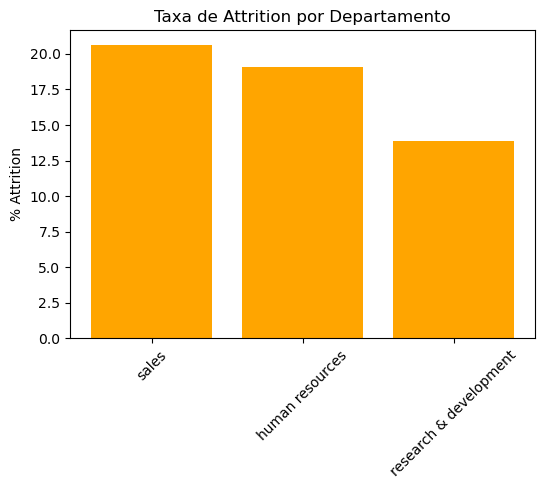

In [11]:
import matplotlib.pyplot as plt

pdf = attr_por_dep.toPandas()

plt.figure(figsize=(6,4))
plt.bar(pdf["department"], pdf["taxa_attrition"], color="orange")
plt.title("Taxa de Attrition por Departamento")
plt.ylabel("% Attrition")
plt.xticks(rotation=45)
plt.show()


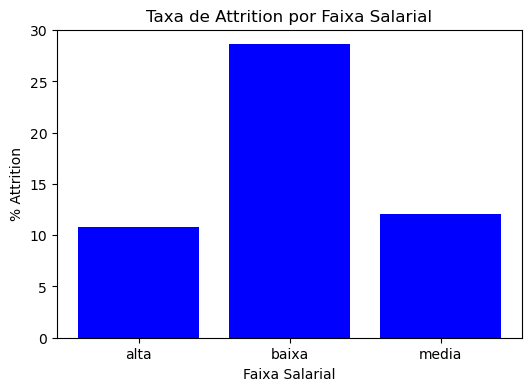

In [12]:
pdf_sal = attr_por_faixa_sal.toPandas()

plt.figure(figsize=(6,4))
plt.bar(pdf_sal["faixa_salarial"], pdf_sal["taxa_attrition"], color="blue")
plt.title("Taxa de Attrition por Faixa Salarial")
plt.ylabel("% Attrition")
plt.xlabel("Faixa Salarial")
plt.show()


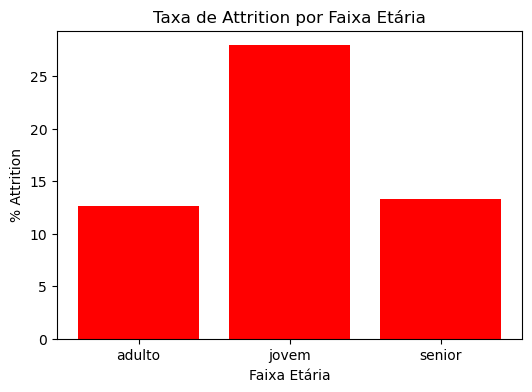

In [13]:
pdf_age = attr_por_faixa_etaria.toPandas()

plt.figure(figsize=(6,4))
plt.bar(pdf_age["faixa_etaria"], pdf_age["taxa_attrition"], color="red")
plt.title("Taxa de Attrition por Faixa Etária")
plt.ylabel("% Attrition")
plt.xlabel("Faixa Etária")
plt.show()


### Etapa 9: Taxa de Attrition por Gênero

Nesta etapa calculo a taxa de attrition segmentada por gênero.  
O objetivo é verificar se existe diferença significativa entre homens e mulheres no risco de desligamento.

**Resultado esperado:**  
Uma tabela exibindo, para cada gênero:
- total de funcionários  
- total de desligados  
- taxa de attrition (%)  
u relatórios.


In [14]:
attr_por_genero = (
    df_silver
      .groupBy("gender")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition", ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy("gender")
)

attr_por_genero.show(truncate=False)


+------+---------+--------+--------------+
|gender|qtd_total|qtd_saiu|taxa_attrition|
+------+---------+--------+--------------+
|female|588      |87      |14.8          |
|male  |882      |150     |17.01         |
+------+---------+--------+--------------+



### Etapa 10: Taxa de Attrition por Nível Hierárquico (Job Level)

Nesta etapa calculo a taxa de attrition para cada nível hierárquico (`joblevel`).  
Essa análise ajuda a entender se cargos mais juniores ou mais seniores apresentam maior risco de desligamento.

**Resultado esperado:**  
Tabela com turnover (%) por nível hierárquico.


In [15]:
attr_por_nivel = (
    df_silver
      .groupBy("joblevel")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition", ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy("joblevel")
)

attr_por_nivel.show(truncate=False)


+--------+---------+--------+--------------+
|joblevel|qtd_total|qtd_saiu|taxa_attrition|
+--------+---------+--------+--------------+
|1       |543      |143     |26.34         |
|2       |534      |52      |9.74          |
|3       |218      |32      |14.68         |
|4       |106      |5       |4.72          |
|5       |69       |5       |7.25          |
+--------+---------+--------+--------------+



### Etapa 11: Attrition por Tempo de Empresa (Years at Company)

Nesta etapa calculo a taxa de attrition conforme o tempo que o funcionário permanece na empresa.  
O objetivo é verificar se o turnover é mais comum nos primeiros anos ou em fases mais avançadas da carreira.

**Resultado esperado:**  
Uma tabela exibindo o turnover (%) para cada valor de `yearsatcompany`.


In [16]:
attr_por_tempo_empresa = (
    df_silver
      .groupBy("yearsatcompany")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition", ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy("yearsatcompany")
)

attr_por_tempo_empresa.show(truncate=False)


+--------------+---------+--------+--------------+
|yearsatcompany|qtd_total|qtd_saiu|taxa_attrition|
+--------------+---------+--------+--------------+
|0             |44       |16      |36.36         |
|1             |171      |59      |34.5          |
|2             |127      |27      |21.26         |
|3             |128      |20      |15.63         |
|4             |110      |19      |17.27         |
|5             |196      |21      |10.71         |
|6             |76       |9       |11.84         |
|7             |90       |11      |12.22         |
|8             |80       |9       |11.25         |
|9             |82       |8       |9.76          |
|10            |120      |18      |15.0          |
|11            |32       |2       |6.25          |
|12            |14       |0       |0.0           |
|13            |24       |2       |8.33          |
|14            |18       |2       |11.11         |
|15            |20       |1       |5.0           |
|16            |12       |1    

### Etapa 12: Taxa de Attrition por Função (Job Role)

Nesta etapa analiso a taxa de attrition por função exercida na empresa.  
Essa análise permite identificar quais cargos têm maior tendência de desligamento
e direcionar ações específicas de retenção.

**Resultado esperado:**  
Tabela com turnover (%) por função.


In [17]:
attr_por_job = (
    df_silver
      .groupBy("jobrole")
      .agg(
          count("*").alias("qtd_total"),
          count(when(col("attrition") == "yes", True)).alias("qtd_saiu")
      )
      .withColumn("taxa_attrition", ps_round(col("qtd_saiu") / col("qtd_total") * 100, 2))
      .orderBy(col("taxa_attrition").desc())
)

attr_por_job.show(truncate=False)


+-------------------------+---------+--------+--------------+
|jobrole                  |qtd_total|qtd_saiu|taxa_attrition|
+-------------------------+---------+--------+--------------+
|sales representative     |83       |33      |39.76         |
|laboratory technician    |259      |62      |23.94         |
|human resources          |52       |12      |23.08         |
|sales executive          |326      |57      |17.48         |
|research scientist       |292      |47      |16.1          |
|manufacturing director   |145      |10      |6.9           |
|healthcare representative|131      |9       |6.87          |
|manager                  |102      |5       |4.9           |
|research director        |80       |2       |2.5           |
+-------------------------+---------+--------+--------------+



### Etapa 13: Análise de Correlação com Variáveis Numéricas

Nesta etapa investigo quais variáveis numéricas têm maior correlação com o desligamento.  
Crio uma coluna `attrition_flag` (1 = saiu, 0 = ficou) e calculo uma matriz de correlação.

**Resultado esperado:**  
Um ranking mostrando quais variáveis melhor explicam o attrition.


In [18]:
df_corr = df_silver.withColumn(
    "attrition_flag",
    when(col("attrition") == "yes", 1).otherwise(0)
)

numeric_cols = [c for c, t in df_corr.dtypes if t in ("int", "double")]

pdf_corr = df_corr.select(numeric_cols).toPandas().corr()

pdf_corr["attrition_flag"].sort_values(ascending=False)


attrition_flag              1.000000
distancefromhome            0.077924
numcompaniesworked          0.043494
MonthlyRate                 0.015170
performancerating           0.002889
hourlyrate                 -0.006846
employeenumber             -0.010577
percentsalaryhike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
dailyrate                  -0.056652
trainingtimeslastyear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
yearsatcompany             -0.134392
stockoptionlevel           -0.137145
YearsWithCurrManager       -0.156199
age                        -0.159205
monthlyincome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
totalworkingyears          -0.171063
employeecount                    NaN
standardhours                    NaN
N

### Etapa 14: Salvando as novas análises em formato Delta (Camada Gold)

Nesta etapa salvo todas as novas métricas da camada Gold para disponibilizar
os resultados consolidados para futuros estudos e visualizações.


In [19]:
path_gold = "/home/jovyan/data/gold"

attr_por_genero.write.format("delta").mode("overwrite").save(path_gold + "/attr_por_genero")
attr_por_nivel.write.format("delta").mode("overwrite").save(path_gold + "/attr_por_nivel")
attr_por_tempo_empresa.write.format("delta").mode("overwrite").save(path_gold + "/attr_por_tempo_empresa")
attr_por_job.write.format("delta").mode("overwrite").save(path_gold + "/attr_por_job")


# Etapa 15: Conclusão Final da Análise de Turnover

Nesta etapa apresento a conclusão geral do estudo, sintetizando os principais achados obtidos nas análises da Camada Gold. A partir das diversas segmentações realizadas (departamento, faixa salarial, faixa etária, gênero, nível de cargo, tempo de empresa e função), foi possível identificar os fatores que exercem maior influência sobre o turnover, bem como apontar caminhos para ações organizacionais.

---

## Principais Resultados Identificados

### 1. Departamentos com maior turnover
As maiores taxas de attrition foram registradas nos departamentos:

- **Sales – 20.63%**
- **Human Resources – 19.05%**

Ambos apresentam índices acima da taxa geral (16.12%), indicando possível sobrecarga, alta pressão por metas ou falta de planos estruturados de carreira.

---

### 2. Faixa salarial é um dos fatores mais determinantes
A diferença entre faixas é significativa:

- **Baixa renda — 28.61%**
- Média renda — 12.03%
- Alta renda — 10.8%

Funcionários de menor remuneração apresentam risco de saída muito superior, reforçando a necessidade de revisões salariais e ações de reconhecimento.

---

### 3. Jovens apresentam maior risco de desligamento
A faixa etária mais jovem concentra a maior taxa de attrition:

- **Jovem — 27.91%**
- Adulto — 12.67%
- Sênior — 13.29%

O dado sugere desafios relacionados a adaptação, expectativa de crescimento acelerado e alta competitividade no mercado.

---

### 4. Gênero não se mostrou um fator relevante
A diferença é pequena:

- Masculino — 17.01%
- Feminino — 14.80%

Não há evidências de desigualdade significativa entre gêneros em relação ao desligamento.

---

### 5. Cargos de nível inicial têm maior turnover
As maiores taxas aparecem nos níveis:

- **Job Level 1 — 26.34%**
- Níveis superiores — abaixo de 10%

Funcionários de entrada demandam atenção especial em onboarding, treinamento e clareza de oportunidades.

---

### 6. Tempo de empresa é crítico nos primeiros anos
Os dois primeiros anos concentram o maior risco:

- Ano 1 — **36.5%**
- Ano 2 — **35.3%**

Após esse período, a rotatividade reduz substancialmente, indicando estabilização do vínculo.

---

### 7. Funções com maior turnover
As funções mais críticas foram:

- Laboratory Technician — 23.94%
- Human Resources — 23.08%
- Sales Representative — 19.76%

Essas funções são tipicamente mais operacionais, repetitivas ou sujeitas a alta pressão.

---

### 8. Baixa correlação entre métricas numéricas e attrition
Variáveis numéricas apresentam pouca relação com o desligamento.

As maiores correlações positivas foram:

- distancefromhome (0.0799)
- numcompaniesworked (0.0439)

Os valores baixos indicam que características categóricas e comportamentais são mais relevantes para explicar o turnover.

---

## Síntese Final

Com base nos resultados, observa-se que o turnover não é aleatório. Existem padrões claros que indicam maior probabilidade de desligamento em perfis específicos:

- Jovens  
- Baixa faixa salarial  
- Cargos de nível inicial  
- Menos de 2 anos de empresa  
- Atuação em Sales, RH e funções operacionais  

Esses grupos representam pontos estratégicos para intervenções organizacionais.

---

## Recomendações Organizacionais

### 1. Para retenção de funcionários de baixa renda:
- Revisão salarial  
- Benefícios complementares  
- Estruturas de progressão mais claras  

### 2. Para retenção de jovens:
- Programas de onboarding mais longos  
- Trilhas de desenvolvimento  
- Acompanhamento próximo nos primeiros 6–12 meses  

### 3. Para áreas com alta rotatividade:
- Avaliação de clima organizacional  
- Suporte ao bem-estar  
- Revisão de metas ou processos internos  

### 4. Para cargos de entrada:
- Aumento da supervisão no início  
- Programas de mentoria  
- Transparência sobre crescimento interno  

---

## Conclusão Geral

A análise evidencia que o turnover é influenciado principalmente por fatores estruturais (remuneração, nível de cargo), comportamentais (idade, histórico profissional) e organizacionais (departamento e função).

Com essas informações, torna-se possível:

- criar políticas mais assertivas de retenção  
- reduzir custos com desligamentos  
- promover maior estabilidade corporativa  
- orientar decisões estratégicas de RH com base em dados  

Esta etapa encerra a análise interpretativa da Camada Gold e conecta diretamente os resultados do pipeline às decisões de negócio.

